# Pose Estimation

In this notebook, we will create a yoga pose classifier. This take an input image and find the best match from the available yoga pose information we have. The classifier will extact the images key-point's and find the closest matching pose according to similarity metrics. 

Current avaialble yoga poses:
- Camel
- Crescent Lunge
- Downward Dog
- Extended Triangle
- Warrior

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.spatial.transform import Rotation as R

from dtaidistance import dtw
from os import listdir
from os.path import isfile, join
import itertools

In [3]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

POSE_LANDMARKS = [m.name for m in mp_pose.PoseLandmark]
index_to_body_mapping = {i:body_part for i, body_part in enumerate(POSE_LANDMARKS)}

## Apply Pose estimation model  to static picture and plot in 3D

In [4]:
def _normalize_color(color):
     return tuple(v / 255. for v in color)


def get_filenames_in_folder(folder_path: str):
    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    return onlyfiles
    

def cosine_similairity(vector_a, vector_b):
    num = np.dot(vector_a, vector_b)
    den = np.linalg.norm(vector_a) * np.linalg.norm(vector_b) 
    cos_similarity = np.divide(num, den)
    return cos_similarity


def get_euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)



def get_valid_pose_folder_names(folder_dir, must_start_with_pose=True):
    subfolders = os.listdir(folder_dir) 

    # Get valid folders
    valid_folders = []
    for subfolder in subfolders:
        bool_clause = must_start_with_pose = subfolder.startswith("pose")
        if bool_clause and os.path.isdir(os.path.join(folder_dir, subfolder)):
            valid_folders.append(subfolder)

    return valid_folders

# Make df
def create_pose_classification_df(folder_dir):
    valid_folders = get_valid_pose_folder_names(folder_dir)

    # print("valid_folders", valid_folders)

    rows = []
    for valid_folder in valid_folders:
        subfolder_pose_type = valid_folder.split("pose_")[1]

        subfolder_path = os.path.join(folder_dir, valid_folder)
        subfiles = os.listdir(subfolder_path) 

        for file in subfiles:
            if ".ipynb_checkpoints" in file:
                continue
            rows.append([os.path.join(subfolder_path, file), subfolder_pose_type])


    columns = ["image_path", "pose_type"]
    pose_classification_df = pd.DataFrame(data=rows, columns=columns)
    
    return pose_classification_df



def calculate_similarity_metrics_from_pose_dfs(pose_a_df, pose_b_df):

    model_a_points = pose_a_df[["x", "y", "z"]].values
    model_a_confidence = pose_a_df.visibility.values
    assert len(model_a_points) == len(model_a_confidence)

    model_b_points = pose_b_df[["x", "y", "z"]].values
    model_b_confidence = pose_b_df.visibility.values
    assert len(model_b_points) == len(model_b_confidence)
    
    cos_similarity_dict = {}
    
    for i_pose, (v1, v2, conf_a, conf_b) in enumerate(zip(model_a_points, model_b_points, model_a_confidence, model_b_confidence)):
        v1 = np.array(v1)
        v2 = np.array(v2)
        body_part = index_to_body_mapping[i_pose]
        cos_similarity = cosine_similairity(v1, v2)
        euclidean_distance = get_euclidean_distance(v1, v2)
        weighted_cos_similarity = conf_a * cos_similarity
        similarity_dict = {
            "v_a" : v1,
            "v_b" : v2,
            "conf_a" : conf_a,
            "conf_b" : conf_b,
            "cos_similarity": cos_similarity,
            # "euclidean_cos_similarity": euclidean_cos_similarity,
            "euclidean_distance": euclidean_distance,
            "weighted_cos_similarity": weighted_cos_similarity,
        }
        
        cos_similarity_dict[body_part] = similarity_dict

    return cos_similarity_dict


def get_metric_mean_differences(aggregate_similarity_pose_metrics, plot=False):
    metric_means = {} 
    for metric in ['cos_similarity', 'weighted_cos_similarity', 'euclidean_distance']:
        
        metric_arr = []
        for comp_images in aggregate_similarity_pose_metrics.keys():
            m_dict = aggregate_similarity_pose_metrics[comp_images]
            metric_arr.append(m_dict[metric])
            
        metric_means[metric] = np.mean(metric_arr)
        
    if plot:
        fake_plot_metric_means = {}
        for k, v in metric_means.items():
            fake_plot_metric_means[k] = [v]
        
        df = pd.DataFrame(fake_plot_metric_means)

        fig, ax = plt.subplots(figsize=(10, 10))
        df.plot.bar(ax=ax)
        plt.show()
    
    return metric_means


def generate_pose_landmarks(input_img, min_detection_confidence=0.75, model_complexity=2):
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=min_detection_confidence, model_complexity=model_complexity, 
    ) as pose:
        input_results = pose.process(input_img)

        landmark_body_arr = []
        for i, landmark in enumerate(input_results.pose_world_landmarks.landmark):
            body_part = index_to_body_mapping[i]
            landmark_body_arr.append([body_part, landmark.x, landmark.y, landmark.z, landmark.visibility])

        columns = ["pose_landmark", "x", "y", "z", "visibility"]
        input_landmark_pose_df = pd.DataFrame(data=landmark_body_arr, columns=columns)
        
    return input_landmark_pose_df

In [31]:
def within_acceptable_metric(value, value_type):
    assert value_type in ["cos_sim", "weighted_cos_sim", "euclidean_distance"]
    
    if value_type == "cos_sim":
         return value > 0.66
                
    if value_type == "weighted_cos_sim":
         return value > 0.66
                
    if value_type == "euclidean_distance":
         return value < 0.3    


def within_all_acceptable_metric_thresholds(max_cos_sim_value, max_weight_cos_sim_value, min_euclid_value, any_can_be_true=False):
    any_can_be_true_arr = []
    
    any_can_be_true_arr.append(within_acceptable_metric(max_cos_sim_value, "cos_sim"))
    any_can_be_true_arr.append(within_acceptable_metric(max_weight_cos_sim_value, "weighted_cos_sim"))
    any_can_be_true_arr.append(within_acceptable_metric(min_euclid_value, "euclidean_distance"))

    # Return Statement
    if any_can_be_true:
        return np.any(any_can_be_true_arr)
    else:
        return np.all(any_can_be_true_arr)

    
def get_min_valued_tuple(list_of_tuples):
    min_index = min(range(len(list_of_tuples)), key=lambda i: list_of_tuples[i])
    return min_index

def get_max_valued_tuple(list_of_tuples):
    min_index = max(range(len(list_of_tuples)), key=lambda i: list_of_tuples[i])
    return min_index


def identify_best_pose(agg_means):
    poses = list(agg_means.keys())
    best_metrics = {}
    
    cos_similarity_vals = [(agg_means[p]["cos_similarity"], p) for p in poses]
    weighted_cos_similarity_vals = [(agg_means[p]["weighted_cos_similarity"], p) for p in poses]
    euclidean_distance_vals = [(agg_means[p]["euclidean_distance"], p) for p in poses]

    max_cos_sim_index = get_max_valued_tuple(cos_similarity_vals)
    max_cos_sim_value, selected_pose_cos_sim = cos_similarity_vals[max_cos_sim_index]
    # print("cos_similarity_vals", cos_similarity_vals)
    # print(max_cos_sim_value, selected_pose_cos_sim)
    best_metrics['max_cos_sim_value'] = max_cos_sim_value
    best_metrics['selected_pose_cos_sim'] = selected_pose_cos_sim


    max_weighted_cos_sim_index = get_max_valued_tuple(weighted_cos_similarity_vals)
    max_weight_cos_sim_value, selected_pose_weight_cos_sim = weighted_cos_similarity_vals[max_weighted_cos_sim_index]
    # print("weighted_cos_similarity_vals", weighted_cos_similarity_vals)
    best_metrics["max_weight_cos_sim_value"] = max_weight_cos_sim_value
    best_metrics['selected_pose_weight_cos_sim'] = selected_pose_weight_cos_sim
    # print(max_weight_cos_sim_value, selected_pose_weight_cos_sim)
    
    min_euclid_index = get_min_valued_tuple(euclidean_distance_vals)
    min_euclid_value, selected_pose_euclid = euclidean_distance_vals[min_euclid_index]
    # print("euclidean_distance_vals", euclidean_distance_vals)
    # print(min_euclid_value, selected_pose_euclid)
    best_metrics['min_euclid_value'] = min_euclid_value
    best_metrics['selected_pose_euclid'] = selected_pose_euclid
    
    print(best_metrics)

    equal_results = selected_pose_euclid == selected_pose_cos_sim == selected_pose_weight_cos_sim
    print("equal_results", equal_results)
    bool_within_acceptable_metric = within_all_acceptable_metric_thresholds(max_cos_sim_value, max_weight_cos_sim_value, min_euclid_value)
    print("bool_within_acceptable_metric", bool_within_acceptable_metric)
            
    if equal_results and bool_within_acceptable_metric:
        print("All thresholds agree")
        return selected_pose_cos_sim, 1.0
    else:
        if within_acceptable_metric(max_cos_sim_value, "cos_sim"):
            print("cosine similarity threshold met")
            return selected_pose_cos_sim, 0.5
        elif within_acceptable_metric(max_cos_sim_value, "weighted_cos_sim"):
            print("weighted cosine similarity threshold met")
            return selected_pose_weight_cos_sim, 0.3
        elif within_acceptable_metric(max_cos_sim_value, "euclidean_distance"):
            print("euclidean_distance threshold met")
            return selected_pose_euclid, 0.2
        else:
            if equal_results and not bool_within_acceptable_metric:
                print("All outside of threshold - but all agree")
                return selected_pose_cos_sim, 0.5
            else:   
                print("No matching poses found")
                return None, 0


In [23]:
def read_and_display_image(img_path, true_pose):
    input_img = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
    plt.title(f"True Pose: {true_pose}", fontsize=18)
    plt.imshow(input_img)
    plt.show()
    
    return input_img


def flip_image_horizontally(img_rgb):
    image = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    flip_image = cv2.flip(image, 1)
    
    flip_rgb_image = cv2.cvtColor(flip_image, cv2.COLOR_BGR2RGB)
    return flip_rgb_image


def custom_plot_landmarks_from_df(
    landmark_df,
    ax=None,
    add_connections: bool = True,
    landmark_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.RED_COLOR, thickness=5),
    connection_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.BLACK_COLOR, thickness=5),
    visibility_threshold=0.5,
    presence_threshold=0.5,
):
    """Plot the landmarks and the connections in matplotlib 3d.
    Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.
    Raises:
    ValueError: If any connetions contain invalid landmark index.
    """
    if landmark_df is None:
        return
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=10, azim=10)
    
    plotted_landmarks = {}
    for i_row, landmark_dict in landmark_df.iterrows():
        if (('visibility' in landmark_dict) and (landmark_dict["visibility"] < visibility_threshold)) or \
        (('presence' in landmark_dict) and (landmark_dict['presence'] < presence_threshold)):
            continue
            
        ax.scatter3D(
            xs=[-landmark_dict['z']],
            ys=[landmark_dict['x']],
            zs=[-landmark_dict['y']],
            color=_normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness
        )
        plotted_landmarks[i_row] = (-landmark_dict['z'], landmark_dict['x'], -landmark_dict['y'])
        
    if add_connections:
        num_landmarks = landmark_df.shape[0]
        
        # Draws the connections if the start and end landmarks are both visible.
        connections = mp_pose.POSE_CONNECTIONS
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                ]
                ax.plot3D(
                    xs=[landmark_pair[0][0], landmark_pair[1][0]],
                    ys=[landmark_pair[0][1], landmark_pair[1][1]],
                    zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    color=_normalize_color(connection_drawing_spec.color[::-1]),
                    linewidth=connection_drawing_spec.thickness
                )

    return ax


def flip_points_horizontally_degrees(points_df, degrees=180):
    rotated_points_df = points_df.copy()

    r_y_180 = R.from_euler('xyz',(0,degrees,0), degrees=True) 
    xyz_rotated = r_y_180.apply(rotated_points_df[["x", "y", "z"]].values.tolist())
    
    rotated_points_df["x"] = xyz_rotated.T[0]
    rotated_points_df["y"] = xyz_rotated.T[1]
    rotated_points_df["z"] = xyz_rotated.T[2]

    return rotated_points_df



def flip_points_vertically_degrees(points_df, degrees=180):
    rotated_points_df = points_df.copy()

    r_y_180 = R.from_euler('xyz',(degrees, 0,0), degrees=True) 
    xyz_rotated = r_y_180.apply(rotated_points_df[["x", "y", "z"]].values.tolist())
    
    rotated_points_df["x"] = xyz_rotated.T[0]
    rotated_points_df["y"] = xyz_rotated.T[1]
    rotated_points_df["z"] = xyz_rotated.T[2]

    return rotated_points_df
    


def get_pose_similarity_comparisson_dict(input_landmark_pose_df, available_pose_names, base_pose_dir):
    pose_scoring_dict = {}

    for pose_name in available_pose_names:
        if pose_name not in pose_scoring_dict:
            pose_scoring_dict[pose_name] = {
                'cos_similarity': [],
                'weighted_cos_similarity': [],
                'euclidean_distance': []
            }

        single_pose_folder = os.path.join(base_pose_dir, pose_name)
        single_pose_files = os.listdir(single_pose_folder)

        for file in single_pose_files:
            if not ".csv" in file:
                continue

            curr_df = pd.read_csv(os.path.join(single_pose_folder, file))
            aggregated_similarity_metrics = calculate_similarity_metrics_from_pose_dfs(pose_a_df=input_landmark_pose_df, pose_b_df=curr_df)
            diff_dict = get_metric_mean_differences(aggregated_similarity_metrics, plot=False)

            pose_scoring_dict[pose_name]["cos_similarity"].append(diff_dict["cos_similarity"])
            pose_scoring_dict[pose_name]["weighted_cos_similarity"].append(diff_dict["weighted_cos_similarity"])
            pose_scoring_dict[pose_name]["euclidean_distance"].append(diff_dict["euclidean_distance"])
            
    return pose_scoring_dict


def get_predicted_pose(pose_scoring_dict):
    # Calc aggregate scores
    agg_means = {}
    for pose, data in pose_scoring_dict.items():
        agg_means[pose] = {}

        for metric, arr in data.items():
            agg_means[pose][metric] = np.mean(arr)

    predicted_pose, confidence = identify_best_pose(agg_means)
    return predicted_pose, confidence

    
def predict_image_pose_from_image(input_img, available_pose_names, base_pose_dir, plot_3d_img=False, compare_with_flipped_image=False):
    input_landmark_pose_df = generate_pose_landmarks(input_img)
    
    if plot_3d_img:
        # Plot the 3D constuction
        custom_plot_landmarks_from_df(input_landmark_pose_df)
    
    pose_scoring_dict = get_pose_similarity_comparisson_dict(input_landmark_pose_df, available_pose_names, base_pose_dir)
    
    selected_predicted_pose, selected_confidence = get_predicted_pose(pose_scoring_dict)
    print("< ==================================================== >")
    
    if compare_with_flipped_image:
        flipped_img = flip_image_horizontally(input_img)
        flipped_input_landmark_pose_df = generate_pose_landmarks(flipped_img)
        
        if plot_3d_img:
            # Plot the 3D constuction
            custom_plot_landmarks_from_df(flipped_input_landmark_pose_df)
        
        flipped_pose_scoring_dict = get_pose_similarity_comparisson_dict(flipped_input_landmark_pose_df, available_pose_names, base_pose_dir)
        flipped_predicted_pose, flipped_confidence = get_predicted_pose(flipped_pose_scoring_dict)
        
        if selected_predicted_pose is None or selected_confidence < flipped_confidence:
            print(f"Selected Flipped image (conf={flipped_confidence}) over normal (conf={selected_confidence})")
            selected_confidence, selected_predicted_pose = flipped_confidence, flipped_predicted_pose
        print("<? ==================================================== ?>")

    
    return selected_predicted_pose, selected_confidence
    

## Code Starts

In [7]:
folder_dir = "inputs/yoga_poses/"
csv_folder_dir = os.path.join(folder_dir, "pose_classification.csv")

create_new_pose_classification_df = False

if create_new_pose_classification_df:
    pose_classification_df = create_pose_classification_df(folder_dir)
    pose_classification_df.to_csv(csv_folder_dir, index=False)
else:
    pose_classification_df = pd.read_csv(csv_folder_dir)

pose_classification_df.head()

,image_path,pose_type
0,inputs/yoga_poses/pose_crescent_lunge/3.jpg,crescent_lunge
1,inputs/yoga_poses/pose_crescent_lunge/1.jpg,crescent_lunge
2,inputs/yoga_poses/pose_crescent_lunge/2.jpg,crescent_lunge
3,inputs/yoga_poses/pose_camel/3.jpg,camel
4,inputs/yoga_poses/pose_camel/1.jpeg,camel


In [8]:
# Populate df with pose info

create_new_csvs= False

if create_new_csvs:
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
    ) as pose:
        for i_row, df in pose_classification_df.iterrows():
            image_path = df["image_path"]        
            pose_dir = os.path.dirname(image_path)
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            results = pose.process(image)

            landmark_body_arr = []
            for i, landmark in enumerate(results.pose_world_landmarks.landmark):
                body_part = index_to_body_mapping[i]
                landmark_body_arr.append([body_part, landmark.x, landmark.y, landmark.z, landmark.visibility])

            columns = ["pose_landmark", "x", "y", "z", "visibility"]
            landmark_pose_df = pd.DataFrame(data=landmark_body_arr, columns=columns)
            landmark_pose_df.to_csv(os.path.join(pose_dir, f"{base_name}_landmarks_holistic_0-75_2.csv"), index=False)    


## 1.) Get input Image

{'max_cos_sim_value': 0.7821502599244246, 'selected_pose_cos_sim': 'pose_downwards_dog', 'max_weight_cos_sim_value': 0.6096006203681088, 'selected_pose_weight_cos_sim': 'pose_downwards_dog', 'min_euclid_value': 0.29476428733873766, 'selected_pose_euclid': 'pose_downwards_dog'}
equal_results True
bool_within_acceptable_metric False
cosine similarity threshold met
< ==================================================== >
{'max_cos_sim_value': 0.3862082364235378, 'selected_pose_cos_sim': 'pose_extended_triangle', 'max_weight_cos_sim_value': 0.2584601601744315, 'selected_pose_weight_cos_sim': 'pose_downwards_dog', 'min_euclid_value': 0.6593615865972198, 'selected_pose_euclid': 'pose_downwards_dog'}
equal_results False
bool_within_acceptable_metric False
No matching poses found
<? ==================================================== ?>


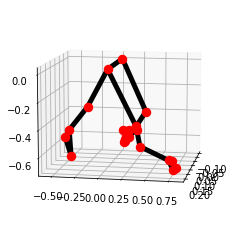

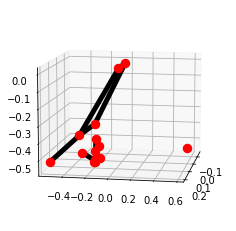

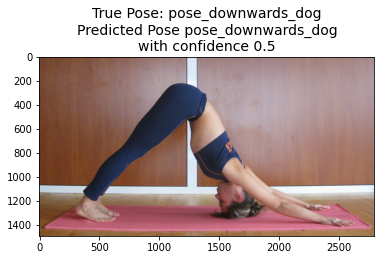

{'max_cos_sim_value': 0.9832951261531302, 'selected_pose_cos_sim': 'pose_warrior', 'max_weight_cos_sim_value': 0.9805646126614858, 'selected_pose_weight_cos_sim': 'pose_warrior', 'min_euclid_value': 0.09337497098705685, 'selected_pose_euclid': 'pose_warrior'}
equal_results True
bool_within_acceptable_metric True
All thresholds agree
< ==================================================== >
{'max_cos_sim_value': 0.9596950565036574, 'selected_pose_cos_sim': 'pose_warrior', 'max_weight_cos_sim_value': 0.9505752798856837, 'selected_pose_weight_cos_sim': 'pose_warrior', 'min_euclid_value': 0.1651673062056419, 'selected_pose_euclid': 'pose_warrior'}
equal_results True
bool_within_acceptable_metric True
All thresholds agree
<? ==================================================== ?>


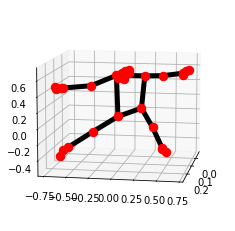

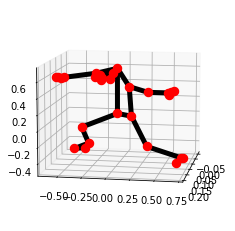

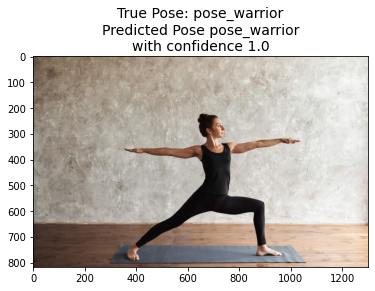

{'max_cos_sim_value': 0.4310146034040921, 'selected_pose_cos_sim': 'pose_warrior', 'max_weight_cos_sim_value': 0.3967376108292273, 'selected_pose_weight_cos_sim': 'pose_warrior', 'min_euclid_value': 0.6461689352858965, 'selected_pose_euclid': 'pose_warrior'}
equal_results True
bool_within_acceptable_metric False
All outside of threshold - but all agree
< ==================================================== >
{'max_cos_sim_value': 0.9749156108822764, 'selected_pose_cos_sim': 'pose_extended_triangle', 'max_weight_cos_sim_value': 0.8870643221467249, 'selected_pose_weight_cos_sim': 'pose_extended_triangle', 'min_euclid_value': 0.12850691582963947, 'selected_pose_euclid': 'pose_extended_triangle'}
equal_results True
bool_within_acceptable_metric True
All thresholds agree
Selected Flipped image (conf=1.0) over normal (conf=0.5)
<? ==================================================== ?>


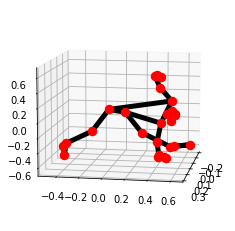

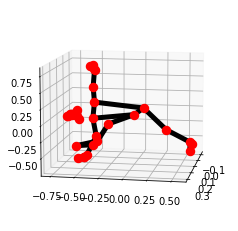

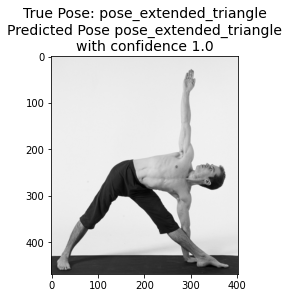

{'max_cos_sim_value': 0.5935763879732803, 'selected_pose_cos_sim': 'pose_crescent_lunge', 'max_weight_cos_sim_value': 0.4983150664379137, 'selected_pose_weight_cos_sim': 'pose_crescent_lunge', 'min_euclid_value': 0.4083948697050363, 'selected_pose_euclid': 'pose_crescent_lunge'}
equal_results True
bool_within_acceptable_metric False
All outside of threshold - but all agree
< ==================================================== >
{'max_cos_sim_value': 0.6558349489727652, 'selected_pose_cos_sim': 'pose_crescent_lunge', 'max_weight_cos_sim_value': 0.523818691674936, 'selected_pose_weight_cos_sim': 'pose_crescent_lunge', 'min_euclid_value': 0.34701018792037647, 'selected_pose_euclid': 'pose_crescent_lunge'}
equal_results True
bool_within_acceptable_metric False
All outside of threshold - but all agree
<? ==================================================== ?>


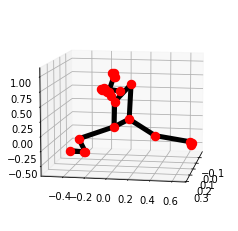

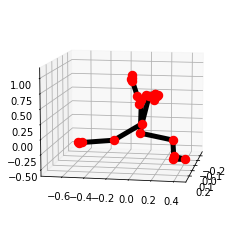

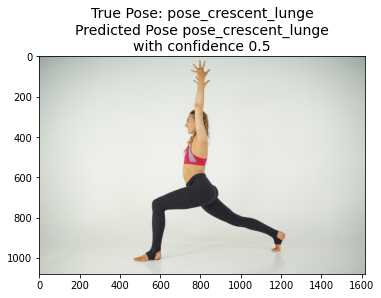

In [32]:
base_pose_dir = "inputs/yoga_poses/"
available_pose_names = get_valid_pose_folder_names(folder_dir)

input_imgs = ["downward_facing_dog.JPG", "warrior.jpg", "extended_triangle.png", "crescent_lunge.jpg"]
input_img_paths = [os.path.join("inputs/yoga_poses/test_poses/", f) for f in input_imgs]

true_poses = ["pose_downwards_dog", "pose_warrior", "pose_extended_triangle", "pose_crescent_lunge"]


for input_image_path, true_pose in zip(input_img_paths, true_poses):
    # Read in image
    input_img = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
    # Get predicted pose
    predicted_pose, selected_confidence = predict_image_pose_from_image(input_img, available_pose_names, base_pose_dir, plot_3d_img=True, compare_with_flipped_image=True)

    # print(f"Prediction is {predicted_pose==true_pose}")
    # print(f"Predicted: {predicted_pose} vs True: {true_pose}")
    
    fig, ax = plt.subplots()
    title = f"True Pose: {true_pose}\nPredicted Pose {predicted_pose}\nwith confidence {selected_confidence}"
    plt.title(title, fontsize=14)
    plt.imshow(input_img)
    plt.show()


## Results

It works!

- The flipping functionality creates a resistence to the dependence (pose direction invariance) on the direction of the input images
    - An idea would be to find the vector between the left shoulder, chest and right shoulder and the transform to be in the same position for each image

 
Issues...
- Algorithm invariant to flips, so select the best matching results when comparing the normal image and the horizontally flipped image.
- Small dataset 
- not using any sub-body part positioning